# Compare model performance


**Context**


# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import pmdarima as pm

# Scaling the data
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Import the seasonal_decompose tool that you saw in the lecture
from statsmodels.tsa.seasonal import seasonal_decompose

#Import the adfuller (Augmented Dicky-Fuller) test
from statsmodels.tsa.stattools import adfuller

from scipy import stats

# Loading stock data (stored locally)

In [2]:
def load_stock_data_locally(path:str) -> pd.DataFrame:
    '''
    This function receives a path (string) indicating where the stock data is stored locally.
    - It loads the stock data as csv file.
    - It takes Date column as index.
    - It transforms the index into Date time index.
    It returns it as a Pandas Dataframe.
    '''
    stock = pd.read_csv(path, index_col='Date')
    stock.index = pd.to_datetime(stock.index)
    return stock

In [3]:
# Retrieve stock data based on ticker and store it locally
ticker='AAPL'
path_ticker = f"../data/raw_data/{ticker}.csv"

df = load_stock_data_locally(path_ticker)
df.head()

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2023-02-14,151.670441,152.234757,149.353807,150.601222,61707600
2023-02-15,153.779190,153.947491,151.353654,151.581353,65573800
2023-02-16,152.175339,154.769175,151.818932,151.977323,68167900
2023-02-17,151.026932,151.472436,149.343908,150.828932,59144100
2023-02-21,146.997559,149.789411,146.928265,148.700387,58867200


# Visuals


In [4]:
def plot_lines_df(df:pd.DataFrame):
    '''
    This function receives a Pandas Dataframe.
    - It selects the numerical features in the input dataframe.
    - It plots lineplots for each numerical feature of input dataframe.
    '''     
    # Numerical Features
    numerical_features = df.select_dtypes(include = 'number').columns.values.tolist()

    #Parameters     
    ncol_max = 1
    nrow_max = len(numerical_features)   
    
    #Figure settings
    fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(8, 15))

    # Flatten axes for easy iteration
    axs = axs.flatten()
    
    for index, col in enumerate(numerical_features):  
        # Plotting the histograms
        sns.lineplot(data = df[numerical_features], y= col, x=df.index,  ax=axs[index])   
        
        # Formatting
        axs[index].set_xlabel(col)
        axs[index].set_title(f'Line Plot - {col}')  
        
        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.8)  # wspace (width), hspace (height)     

In [5]:
def plot_lines_series(series:pd.Series):
    '''
    This function receives a Pandas Series.
    - It plots lineplots for each numerical feature of input series.
    '''     
    assert series.dtype == np.float64 #"series dtype must be a number"
   
    #Figure settings
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plotting the histograms
    sns.lineplot(y= series, x=series.index)   

    # Formatting
    ax.set_xlabel(series.name)
    ax.set_title(f'Line Plot - {series.name}')  

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.8)  # wspace (width), hspace (height)     
    

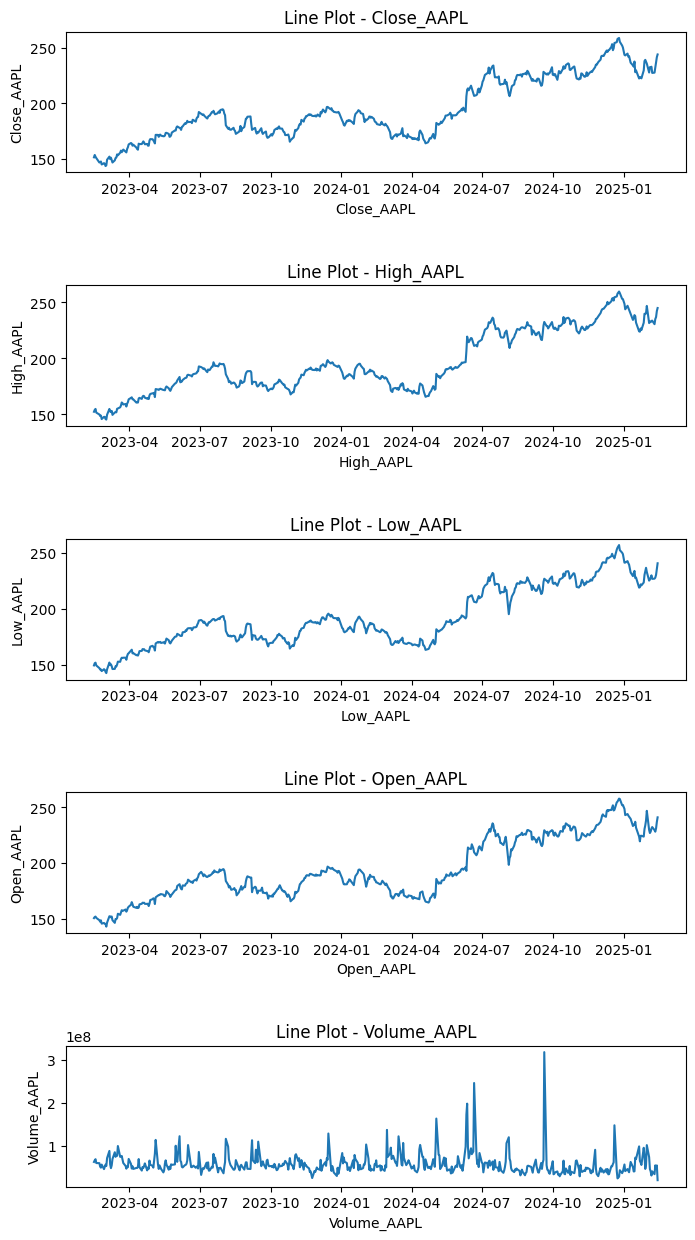

In [6]:
# Lineplots of stock data (all features)
plot_lines_df(df)   

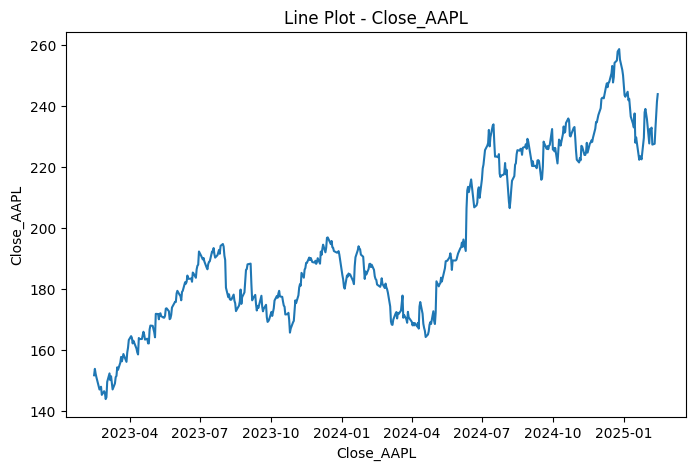

In [7]:
# Lineplots of stock data (1 feature)
target = 'Close_AAPL'
plot_lines_series(df[target])

# ARIMA model


## Stationarity

In [8]:
# Stationarity check 
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column:{column_name}')
    df_test = adfuller(series, autolag='AIC')
    df_output = pd.Series(df_test[0:4], 
                          index=['Test Statistic',
                                 'p-value',
                                 'No Lags Used',
                                 'Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print (df_output)
        
    if df_test[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")       

In [9]:
# Test of stationarity of the data
Augmented_Dickey_Fuller_Test_func(df[target],f"{target}")


Results of Dickey-Fuller Test for column:Close_AAPL
Test Statistic                  -0.961836
p-value                          0.766928
No Lags Used                     1.000000
Number of Observations Used    501.000000
Critical Value (1%)             -3.443470
Critical Value (5%)             -2.867326
Critical Value (10%)            -2.569852
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


## Decomposition


In [10]:
# Fix frequency for seasonal_decompose
df = df.asfreq('B').fillna(method='ffill')  # Forward fill missing values

### Additive decomposition


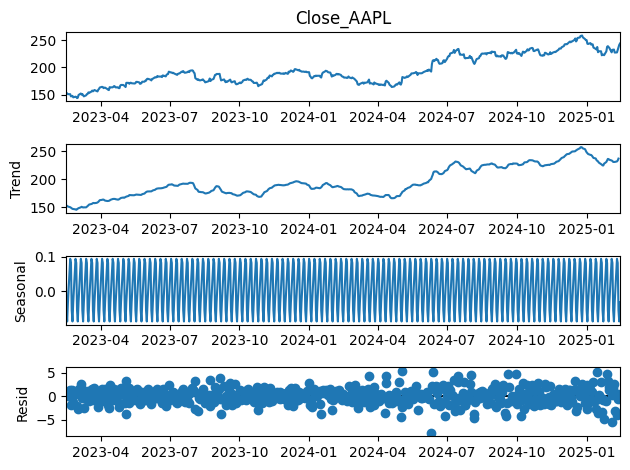

In [11]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_add = seasonal_decompose(df[target], model='additive')
result_add.plot();

### Multiplicative decomposition


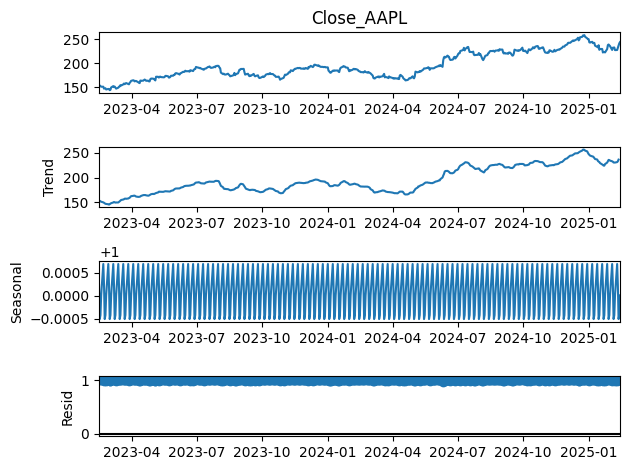

In [12]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df[target], model='multiplicative')
result_mul.plot();

## Auto ARIMA with deseasonalized data


In [19]:
def create_arima_model(df: pd.DataFrame, target:list):
    import pmdarima as pm
    
    # Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
    result_mul = seasonal_decompose(df[target], model='multiplicative')

    # Create a column with seasonality of co2 levels
    df[f"{target}_seasons"] = result_mul.seasonal
    
    # Create a column without seasonality
    df[f"{target}_deseasonalized"] = df[target] / df[f"{target}_seasons"]

    # Search for the best model (i.e find p, d, q)     
    auto_arima = pm.auto_arima(df[f"{target}_deseasonalized"],
                           start_p=1, max_p=2,
                           start_q=1, max_q=2,
                           trend='t',
                           seasonal=False,
                           trace=False)

    # Create and fit the model    
    updated_arima = ARIMA(df[f"{target}_deseasonalized"], order=auto_arima.order)
    updated_arima = updated_arima.fit()    
    
    return updated_arima

In [22]:
# Create ARIMA model (based on deseasonilized data)
arima_mdl = create_arima_model(df, target)

# Summary 
arima_mdl.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Close_AAPL_deseasonalized   No. Observations:                  524
Model:                        ARIMA(0, 1, 0)   Log Likelihood               -1251.888
Date:                       Sat, 15 Feb 2025   AIC                           2505.776
Time:                               14:36:54   BIC                           2510.035
Sample:                           02-14-2023   HQIC                          2507.444
                                - 02-14-2025                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.0248      0.276     25.429      0.000       6.483       7.566
===================================================================================
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):               194.59
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

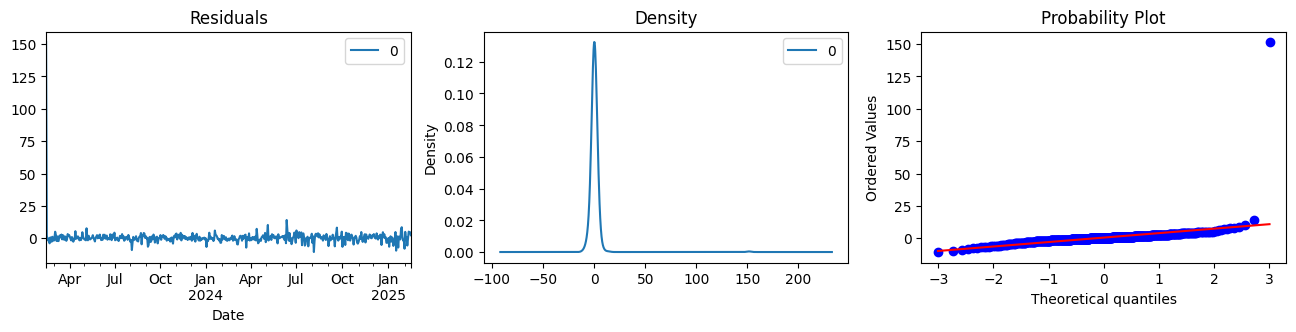

In [18]:
# Check residuals 
residuals = pd.DataFrame(arima_mdl.resid)
fig, ax = plt.subplots(1,3, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);
stats.probplot(residuals[0], dist="norm", plot=ax[2])     
plt.show()

# LSTM model
